In [57]:
import xarray as xr
import pandas as pd
import numpy as np
from cast_to_xarray import *

In [58]:
# extract temperature and salinity at the nearest points to the bottle pH and apply MLR there

In [59]:
data_dir = 'data_cruise2'
fileend = '_loop_filter_teos10_bin.cnv'

cast6 = cast_to_xarray(data_dir+'/station6'+fileend, 'S6')
cast7 = cast_to_xarray(data_dir+'/station7'+fileend, 'S7')
cast8 = cast_to_xarray(data_dir+'/station8'+fileend, 'S8')
cast9 = cast_to_xarray(data_dir+'/slope'+fileend, 'S9')

In [60]:
# load the spec pH data
pH_specpd = pd.read_csv('specpH.csv')

# conver to xarray
pH_spec= pH_specpd.set_index('Station').to_xarray()

In [61]:
pH_spec

<xarray.Dataset>
Dimensions:   (Station: 20)
Coordinates:
  * Station   (Station) int64 6 6 6 6 6 7 7 7 7 7 8 8 8 8 8 9 9 9 9 9
Data variables:
    Pressure  (Station) float64 2.25 43.08 14.03 29.08 ... 85.38 90.25 76.49
    pH        (Station) float64 8.18 8.159 8.18 8.195 ... 8.12 8.152 8.114 8.148
    Oxygen    (Station) float64 239.4 205.8 241.7 225.6 ... 185.1 182.9 230.2

In [62]:
# Extract CTD data at spec pH depths

In [153]:
# add the MLR within the function
# add the O2 MLR as well

def extract_CTD_pred(specstn,castarray):
    specdepths = pH_spec.sel(Station=specstn).Pressure
    
    Tm = 13.20
    Ts = 5.92
    
    Sm = 34.40
    Ss = 1.49
    
    Om = 214.5
    Os = 44.7
    
    CTDtemps = []
    CTDsals = []
    pHests = []
    pHests2 = []
    
    for i in range(len(specdepths)):
        CTDtemp = castarray.sel(depth=specdepths[i], method='nearest', tolerance=1).temperature.values
        CTDtemps.append(CTDtemp.item())
        
        CTDsal = castarray.sel(depth=specdepths[i], method='nearest', tolerance=1).salinity.values
        CTDsals.append(CTDsal.item())
        
        # add MLR into function
        Tnorm = (CTDtemp-Tm)/Ts
        Snorm = (CTDsal-Sm)/Ss
        Onorm = (pH_spec.sel(Station=specstn).Oxygen.values[i]-Om)/Os
        
        pHest = 8.00+(3.59E-2)*Tnorm+(-5.51E-3)*Snorm+(6.84E-3)*Tnorm*Snorm
        pHests.append(pHest)
        
        pHest2 = 8.01+(2.86E-2)*Tnorm+(6.06E-2)*Snorm+(7.82E-2)*Onorm+(-2.09E-2)*Tnorm*Snorm+(-8.24E-3)*Snorm*Onorm
        pHests2.append(pHest2)
    return pHests, pHests2

In [154]:
pHest6, pHest6_2 = extract_CTD_pred(6, cast6)
pHest7, pHest7_2 = extract_CTD_pred(7, cast7)
pHest8, pHest8_2 = extract_CTD_pred(8, cast8)
pHest9, pHest9_2 = extract_CTD_pred(9, cast9)

In [163]:
# combine the pHest
pHestall = [pHest6 + pHest7+ pHest8 + pHest9]
pHest2all = [pHest6_2 + pHest7_2 + pHest8_2 + pHest9_2]

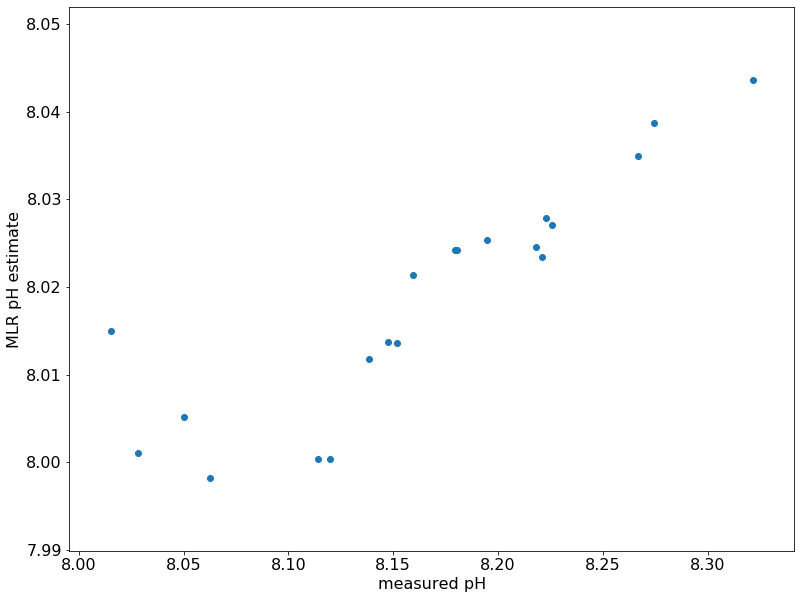

In [169]:
plt.figure(figsize=(13,10))
plt.rcParams.update({'font.size': 16})

plt.scatter(pH_spec.pH.values, pHestall)
plt.xlabel('measured pH')
plt.ylabel('MLR pH estimate')

plt.savefig('pHeval.png')

In [165]:
correlation_matrix = np.corrcoef(pH_spec.pH.values, pHestall)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

0.7795485761682733


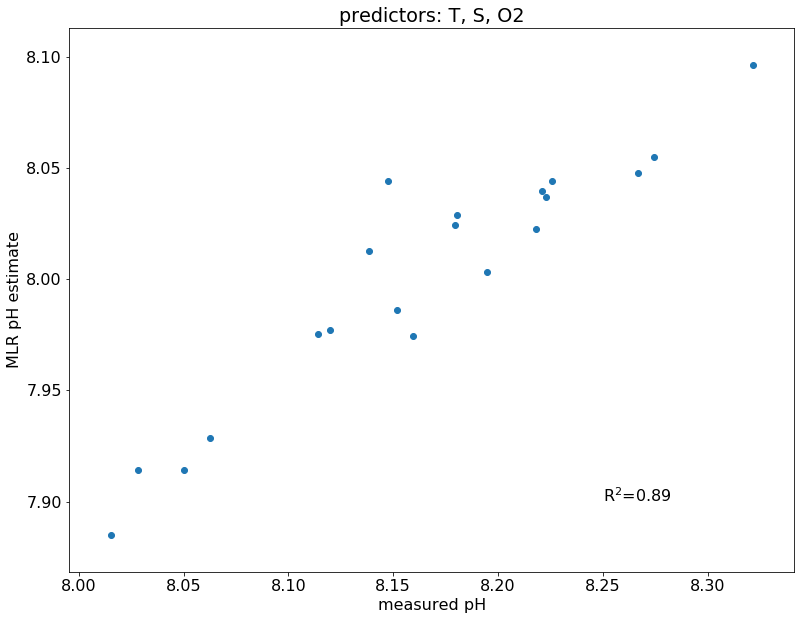

In [170]:
correlation_matrix = np.corrcoef(pH_spec.pH.values, pHest2all)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

#print(r_squared)

plt.figure(figsize=(13,10))
plt.rcParams.update({'font.size': 16})

plt.scatter(pH_spec.pH.values, pHest2all)
plt.xlabel('measured pH')
plt.ylabel('MLR pH estimate')
plt.title('predictors: T, S, O2')

c=round(r_squared,2)
s=str(c)
ss = 'R$^2$='+ s
plt.text(8.25, 7.9, ss)

plt.savefig('pHeval2.png')

0.886871964141069
